In [2]:
import pysam
import collections
import random
import pandas as pd
import numpy as np
%load_ext rpy2.ipython


/shared/conda-install/envs/cgat-devel-lite/lib/python2.7/site-packages/rpy2/robjects/robject.py:6: UserWarning: During startup - 
  rpy2.rinterface.initr()
/shared/conda-install/envs/cgat-devel-lite/lib/python2.7/site-packages/rpy2/robjects/robject.py:6: UserWarning: Warning messages:

  rpy2.rinterface.initr()
/shared/conda-install/envs/cgat-devel-lite/lib/python2.7/site-packages/rpy2/robjects/robject.py:6: UserWarning: 1: package ‘methods’ was built under R version 3.2.4 

  rpy2.rinterface.initr()
/shared/conda-install/envs/cgat-devel-lite/lib/python2.7/site-packages/rpy2/robjects/robject.py:6: UserWarning: 2: package ‘datasets’ was built under R version 3.2.4 

  rpy2.rinterface.initr()
/shared/conda-install/envs/cgat-devel-lite/lib/python2.7/site-packages/rpy2/robjects/robject.py:6: UserWarning: 3: package ‘utils’ was built under R version 3.2.4 

  rpy2.rinterface.initr()
/shared/conda-install/envs/cgat-devel-lite/lib/python2.7/site-packages/rpy2/robjects/robject.py:6: UserWarnin

In [37]:
infile = "/ifs/projects/ians/umisdeduping/iCLIP_deduping/SR_iCLIP_test3/mapping.dir/Nxf1-GFP-R2.bam"

This notebook contains test code to examine whether UMIs at adjacent positions are more similar to one another than we would expect by chance. To test this we will parse the bam file and fill a dictionary: key="[contig][position]", value= counter of UMIs for each position. Then we'll parse the dictionary keys and look to see whether the positions -5, -4 .. to .. +4, +5 exist in the dictionary keys. If they do, we'll compare the umi profiles between the postions (how to do this). We'll also compare with n random positions (will need to see how large n can get before this takes too long).

First, we need to work out how to best compare the UMIs at two positions...

So, what we're really interested in is whether we see the same UMIs at pos1 and pos2. We could look at the intersection of UMIs ignoring the counts and calculate the "fraction intersection". For a more accurate assesment we could add the counts in as weights within this calculation. Where we have two positions with high depth, we would expect a greater intersection fraction. However, when we're comparing pos1 and pos2, the depth at pos2 should be independent of whether it's -1, +1, +5 or a random position. Therefore, we can ignore this (I think!). We'll perform the same comparison with a random position as well which should give us a benchmark for how much similarity we expect by chance.

Ultimately, we want a line graph with position on x, fraction intersection on y and two lines (random or non-random)

Let's start with a function to determine fraction intersection

In [34]:
umis1 = collections.Counter()
umis2 = collections.Counter()
umis1["ATAGT"] = 100
umis1["AGTAG"] = 10
umis1["GCGAT"] = 150

umis2["ATAGT"] = 2
umis2["GACAG"] = 1000
umis2["CCAGA"] = 20

print umis1
print umis2

Counter({'GCGAT': 150, 'ATAGT': 100, 'AGTAG': 10})
Counter({'GACAG': 1000, 'CCAGA': 20, 'ATAGT': 2})


In [4]:
def getIntersecionFraction(counter1, counter2):
    ''' for two counters with string keys,
    return the fraction of intersecting keys'''
    
    set1 = set(counter1.keys())
    set2 = set(counter2.keys())
    total = len(set1) + len(set2)
    fraction = float(len(set1.intersection(set2))) / total
    
    return fraction, total

getIntersecionFraction(umis1, umis2)

(0.16666666666666666, 6)

In [5]:
def getWeightedIntersecionFraction(counter1, counter2):
    ''' for two counters with string keys,
    return the fraction of intersecting keys,
    weighted by the counts of each key'''
        
    set1 = set(counter1.keys())
    set2 = set(counter2.keys())
    intersection = set1.intersection(set2)
    intersection_counts = 0

    for i in intersection:
        intersection_counts += counter1[i]
        intersection_counts += counter2[i]

    total = sum(counter1.values()) + sum(counter2.values())
    fraction = float(intersection_counts) / total

    return fraction, total

getWeightedIntersecionFraction(umis1, umis2)

(0.07956318252730109, 1282)

now let's parse a bam and create the dictionary.

In [38]:
insam = pysam.Samfile(infile, "rb")

umi_pos = collections.defaultdict(lambda:collections.defaultdict(lambda: collections.Counter()))
inreads = insam.fetch()#reference=chrom)
for read in inreads:
    if read.is_unmapped:
        continue

    if read.mate_is_unmapped and paired:
        continue

    if read.is_read2:
        continue

    is_spliced = False

    if read.is_reverse:
        pos = read.aend
        if read.cigar[-1][0] == 4:
            pos = pos + read.cigar[-1][1]
        start = read.pos

        if ('N' in read.cigarstring or
            (read.cigar[0][0] == 4 and
             read.cigar[0][1] > soft_clip_threshold)):
            is_spliced = True
    else:
        pos = read.pos
        if read.cigar[0][0] == 4:
            pos = pos - read.cigar[0][1]
        start = pos

        if ('N' in read.cigarstring or
            (read.cigar[-1][0] == 4 and
             read.cigar[-1][1] > soft_clip_threshold)):
            is_spliced = True

    umi = read.qname.split("_")[-1]
    
    umi_pos[insam.get_reference_name(read.tid)][pos][umi] += 1

In [26]:
read.cigar

[(0, 20)]

In [39]:
n = 0
print len(umi_pos)
for k,v in umi_pos.iteritems():
    n += len(v)
print n

22
739140


Now we need to go through the positions for each contig and compare the UMIs at each position with the UMIs at positions up and downstream and a random position, then build a dataframe.

The final dataframe contains a single value for each distance up and downstream which is the weighted average of the intersection from each position using the counts per position as the weights. 

In [40]:
up_pad = -10
down_pad = 10

######### calculate intersection ############
intersection_fraction_dict = collections.defaultdict(list)
weighted_intersection_fraction_dict = collections.defaultdict(list)
random_intersection_fraction_dict = collections.defaultdict(list)
random_weighted_intersection_fraction_dict = collections.defaultdict(list)
for contig in umi_pos:
    for position in umi_pos[contig]:
        for distance in range(up_pad, down_pad +1, 1):
            if distance == 0:
                continue
            if (position + distance) in umi_pos[contig]:

                random_contig = random.choice(umi_pos.keys())
                random_pos = random.choice(umi_pos[random_contig].keys())
                intersection_fraction_dict[distance].append(getIntersecionFraction(
                        umi_pos[contig][position], umi_pos[contig][position + distance]))
                weighted_intersection_fraction_dict[distance].append(getWeightedIntersecionFraction(
                        umi_pos[contig][position], umi_pos[contig][position + distance]))
                random_intersection_fraction_dict[distance].append(getIntersecionFraction(
                        umi_pos[contig][position], umi_pos[random_contig][random_pos]))
                random_weighted_intersection_fraction_dict[distance].append(getWeightedIntersecionFraction(
                        umi_pos[contig][position], umi_pos[random_contig][random_pos]))
                
######### get average intersection ############
positions = []
fraction_intersection = []
random_fraction_intersection = []

for distance in range(up_pad, down_pad +1,1):
    
    total = 0
    total_fraction = 0
    random_total = 0
    random_fraction = 0

    positions.append(distance)

    if distance == 0:
        fraction_intersection.append(np.nan)
        random_fraction_intersection.append(np.nan)
        continue

    for fraction, count in intersection_fraction_dict[distance]:
        total += count
        total_fraction += fraction * count

    for fraction, count in random_intersection_fraction_dict[distance]:
        random_total += count
        random_fraction += fraction * count
    
    fraction_intersection.append(total_fraction/total)
    random_fraction_intersection.append(random_fraction/random_total)

######### build dataframe ############
control = [0,]* len(positions)
control.extend([1,]* len(positions))
fraction_intersection.extend(random_fraction_intersection)
positions *= 2

df = pd.DataFrame({"control":control,
                   "fraction_intersection":fraction_intersection,
                   "position": positions})
print df.head()

   control  fraction_intersection  position
0        0               0.056297       -10
1        0               0.054569        -9
2        0               0.054490        -8
3        0               0.055672        -7
4        0               0.051476        -6


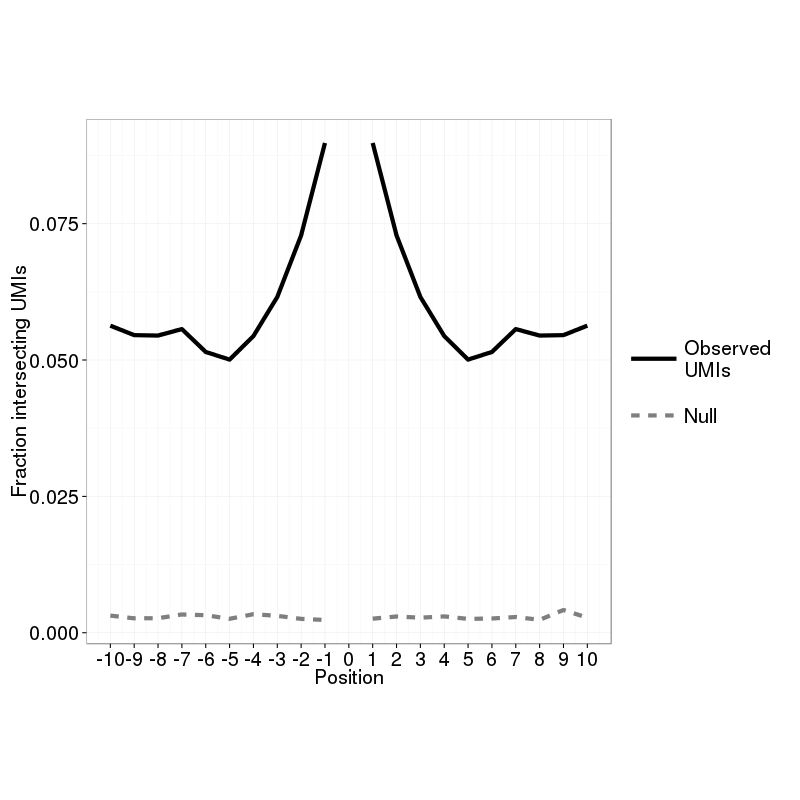

In [41]:
%%R -i df -w 800 -h 800
library(ggplot2)
library(grid)
m_txt = element_text(size=20)

p = ggplot(df, aes(position, fraction_intersection, colour=as.factor(control), group=control)) +
geom_line(size=2, aes(linetype=as.factor(control))) +
scale_colour_manual(name="", values=c("black", "grey50"), labels=c("Observed\nUMIs", "Null")) +
scale_linetype_discrete(name="", labels=c("Observed\nUMIs", "Null")) +
xlab("Position") + ylab("Fraction intersecting UMIs") +
scale_x_continuous(breaks=seq(-10,10,1), limits=c(-10,10)) +
theme_bw() + 
theme(
axis.text=m_txt,
axis.title=m_txt,
legend.text=m_txt,
legend.key.size=unit(2, "cm"),
legend.key = element_blank(),
aspect.ratio=1)

print(p)

I think that this is probably because positions close in space are likely to be highly expressed, and therefore cover a large amount of UMI space, leading to a high overlap.

Two ways around this:
1) Simulate a position with a similar number of UMIs or a similar number of reads

or

2) Pick a base with the same number of UMIS

Two is probably easier to do, so lets do that.

First need to generate the distribution

In [46]:
umi_dist = collections.Counter()
for contig in umi_pos:
    for position in umi_pos[contig]:
        umi_dist += umi_pos[contig][position]

In [57]:
umi_dist = pd.Series(umi_dist, name="count").reset_index()
umi_dist["freq"] = umi_dist["count"] / umi_dist["count"].sum()


In [ ]:
######### calculate intersection ############
intersection_fraction_dict = collections.defaultdict(list)
weighted_intersection_fraction_dict = collections.defaultdict(list)
random_intersection_fraction_dict = collections.defaultdict(list)
random_weighted_intersection_fraction_dict = collections.defaultdict(list)
for contig in umi_pos:
    for position in umi_pos[contig]:
        for distance in range(up_pad, down_pad +1, 1):
            if distance == 0:
                continue
            if (position + distance) in umi_pos[contig]:

                this = umi_pos[contig][position]
                other = umi_pos[contig][position + distance]
                rand_other = {umi: count for umi, count in zip(np.random.choice(umi_dist["index"], 
                                                    size=len(other.keys()),
                                                    replace=False,
                                                    p=umi_dist["freq"]),
                                              other.values())}
                intersection_fraction_dict[distance].append(getIntersecionFraction(this, other))
                weighted_intersection_fraction_dict[distance].append(getWeightedIntersecionFraction(
                        this, other))
                random_intersection_fraction_dict[distance].append(getIntersecionFraction(
                        this, rand_other))
                random_weighted_intersection_fraction_dict[distance].append(getWeightedIntersecionFraction(
                        this, rand_other))
                
######### get average intersection ############
positions = []
fraction_intersection = []
random_fraction_intersection = []

for distance in range(up_pad, down_pad +1,1):
    
    total = 0
    total_fraction = 0
    random_total = 0
    random_fraction = 0

    positions.append(distance)

    if distance == 0:
        fraction_intersection.append(np.nan)
        random_fraction_intersection.append(np.nan)
        continue

    for fraction, count in intersection_fraction_dict[distance]:
        total += count
        total_fraction += fraction * count

    for fraction, count in random_intersection_fraction_dict[distance]:
        random_total += count
        random_fraction += fraction * count
    
    fraction_intersection.append(total_fraction/total)
    random_fraction_intersection.append(random_fraction/random_total)

######### build dataframe ############
control = [0,]* len(positions)
control.extend([1,]* len(positions))
fraction_intersection.extend(random_fraction_intersection)
positions *= 2

df = pd.DataFrame({"control":control,
                   "fraction_intersection":fraction_intersection,
                   "position": positions})
print df.head()